In [1]:
"""
Plot example image chunks from reference data
"""

import os, sys, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

from fiona.crs import from_epsg
from shapely.geometry import box

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
albers = from_epsg(5070)

print(f'Projected CRS: {albers}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:5070
Successfully imported all packages!


In [24]:
def plot_image_chunks(dataset, class_mapping, bands_to_plot, out_file, figsize=(10,10), labelsize=10, rgb_dc=None, rgb_denver=None):
    """
    Plots a single example image chunk for each class with columns representing different bands.
    
    Args:
    - dataset: The dataset containing the image chunks and labels.
    - class_mapping: Dictionary mapping class codes to class labels.
    - bands_to_plot: List of band indices to plot, or 'all' to plot every band in the dataset.
    """
    # Determine which bands to plot
    first_batch = next(iter(dataset))
    num_bands = first_batch['image'].shape[1] if bands_to_plot == 'all' else len(bands_to_plot)
    
    if bands_to_plot == 'all':
        bands_to_plot = list(range(num_bands))
    
    codes = list(class_mapping.values())  # This should be the numeric values (0, 1, 2, etc.)
    classes = list(class_mapping.keys())  # The corresponding class codes (ME, SL, etc.)

    # Store examples for each class
    samples_dict = {cls: None for cls in codes}
    
    # Iterate over the DataLoader to find at least one sample for each class
    for idx, batch in enumerate(dataset):
        # Retrieve the image sample and corresponding label
        images, labels = batch['image'], batch['code']
        
        for i, cls in enumerate(codes):
            if samples_dict[cls] is None:  # If no sample has been found for this class yet
                cls_indices = (labels == cls).nonzero(as_tuple=True)[0]
                if len(cls_indices) > 0:
                    idx = cls_indices[0]  # Take the first available sample
                    samples_dict[cls] = images[idx].numpy()
        
        # Break if samples for all classes have been found
        if all(sample is not None for sample in samples_dict.values()):
            break
    
    print(f"Class dictionary: {samples_dict.keys()}")

    # Plot the collected samples
    fig, axes = plt.subplots(len(codes), num_bands, figsize=figsize, squeeze=False)
    
    for i, cls in class_mapping.items():
        print(i, cls)
        image = samples_dict[i]
        if image is None:
            print(f"No samples available for class {cls}.")
            continue
        print(image.dtype)
        
        # # Check which region this class belongs to and select the correct RGB image
        # if classes[i] in dc_keep and rgb_fp_dc is not None:
        #     rgb_da = rxr.open_rasterio(rgb_fp_dc, masked=True, cache=False).squeeze()
        #     rgb_da = rgb_da.sel(band=[6, 4, 2])  # rgb bands
        # elif classes[i] in denver_keep and rgb_fp_denver is not None:
        #     rgb_da = rxr.open_rasterio(rgb_fp_denver, masked=True, cache=False).squeeze()
        #     rgb_da = rgb_da.sel(band=[6, 4, 2])  # rgb bands
        # else:
        #     print(f"Class {classes[i]} not found in either D.C. or Denver keep list.")
        #     continue
        
    #     # Extract the spatial extent using the image sample's pixel coordinates
    #     height, width = image.shape[1], image.shape[2]  # Height and width in pixel coordinates

    #     # Calculate the window's bounds using the affine transform of rgb_data
    #     transform = rgb_data.rio.transform()  # Get the affine transform of the raster
    #     x_min_spatial, y_min_spatial = rio.transform.xy(transform, 0, 0, offset='ul')
    #     x_max_spatial, y_max_spatial = rio.transform.xy(transform, height - 1, width - 1, offset='lr')
    
    #     # Extract the RGB chunk using these spatial coordinates
    #     try:
    #         rgb_chunk = rgb_data.rio.clip_box(
    #             minx=x_min_spatial, miny=y_min_spatial, 
    #             maxx=x_max_spatial, maxy=y_max_spatial
    #         ).transpose("y", "x", "band").values
    #     except rio.errors.WindowError as e:
    #         print(f"WindowError for class {classes[i]}: {e}")
    #         continue
    
    #     # Normalize and clip RGB values to the valid range
    #     rgb_chunk = np.clip(rgb_chunk / 255.0, 0, 1)  # Ensure values are between 0 and 1 for display
        
    #     # Plot the RGB chunk in the first column
    #     axes[i, 0].imshow(rgb_chunk)
    #     axes[i, 0].axis('off')
        
    #     # Populate the remaining columns
    #     for b, band_idx in enumerate(bands_to_plot):
    #         band_image = image[band_idx, :, :]  # Select the specific band
    #         axes[i, b].imshow(band_image, cmap='gray')  # Use grayscale for single-band images
    #         axes[i, b].axis('off')
            
    #         # Add title for the first row of each band
    #         if i == 0:
    #             if b == 0:
    #                 axes[i, 0].set_title('RGB', fontsize=labelsize)
    #             axes[i, b + 1].set_title(f"{band_mapping[b+1]}", fontsize=labelsize)
            
    #         # Add class label as y-axis title for the first column
    #         if b == 0:
    #             class_label = list(class_mapping.keys())[list(class_mapping.values()).index(cls)]  # Get the class label
    #             axes[i, b].set_ylabel(class_label, fontsize=labelsize, rotation=0, labelpad=40, va='center', ha='right')
    #             axes[i, b].yaxis.set_label_position("left")
    #             axes[i, b].yaxis.tick_left()
    
    # # plt.tight_layout()
    # plt.subplots_adjust(top=0.95, left=0.15)

    # plt.savefig(out_file, dpi=300, bbox_inches='tight')
    # plt.show()

print("Plotting function ready !!!")

Plotting function ready !!!


In [3]:
# Load the reference data for DC
ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
ref_dc = gpd.read_file(ref_fp)
ref_dc = ref_dc.to_crs(albers)
ref_dc.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((1618024.537 1931734.332, 1618025.567..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((1618808.974 1929995.232, 1618810.631..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((1623885.735 1919398.71, 1623891.16 1..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((1628717.795 1926593.614, 1628720.363..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((1623015.124 1919789.523, 1623019.675..."


In [4]:
# Load the reference data for Denver
ref_fp = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
ref_denver = gpd.read_file(ref_fp)
ref_denver = ref_denver.to_crs(albers)
ref_denver.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((-761234.666 1892255.157, -7612..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((-760349.372 1891832.63, -76033..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((-761461.065 1891666.741, -7614..."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((-760668.873 1891805.943, -7606..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((-761279.614 1891782.525, -7612..."


In [5]:
print(ref_dc.class_code.value_counts())
print(ref_denver.class_code.value_counts())

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64
class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [6]:
dc_keep = ['ME', 'SL', 'UR', 'SH']
denver_keep = ['CS', 'WS', 'AP', 'TL', 'CN', 'TG']
# Keep majority classes from each region for example plots
ref_dc_sub = ref_dc[ref_dc['class_code'].isin(dc_keep)]
ref_denver_sub = ref_denver[ref_denver['class_code'].isin(denver_keep)]

In [7]:
# Combine the two reference data sets
ref = pd.concat([ref_dc_sub, ref_denver_sub], ignore_index=True)
list(ref.class_code.unique())

['ME', 'SL', 'UR', 'SH', 'TL', 'WS', 'CN', 'AP', 'TG', 'CS']

In [8]:
ref.class_code.value_counts()

class_code
CS    86561
ME    36864
SL    15267
WS    10642
AP     8117
TL     2843
CN     2757
UR     1279
SH      783
TG      228
Name: count, dtype: int64

In [9]:
# Create a numeric class code 
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
print(class_mapping)

{'ME': 0, 'SL': 1, 'UR': 2, 'SH': 3, 'TL': 4, 'WS': 5, 'CN': 6, 'AP': 7, 'TG': 8, 'CS': 9}


In [10]:
# Identify areas with "pure" material types for examples

In [11]:
print(ref.crs)

PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]


In [12]:
# Create centroids
ref_pt = ref.copy()
ref_pt = ref_pt.to_crs(albers) # wgs for both ROIs
ref_pt['geometry'] = ref_pt['geometry'].centroid

# Define the window size and half window (for boxes)
window_size = 78
half_window = window_size / 2

training_windows = [] # image windows with >50% of specific roof type
training_roof_types = [] # roof type codes for valid windows

# Loop through each footprint individually
for geom, roof_type in zip(ref.geometry, ref['class_code']):
    # calculate the image window as footprint buffer
    centroid = geom.centroid
    window = box(centroid.x - half_window, centroid.y - half_window,
                 centroid.x + half_window, centroid.y + half_window)

    # Intersect with centroids to get class count within window
    intersect = ref_pt[ref_pt.intersects(window)]
    
    # Get the total count and count for the class
    total_count = len(intersect)
    class_count = len(intersect[intersect['class_code'] == roof_type])

    # Check if there is at least 50% of the roof type in that window
    if total_count > 0 and (class_count / total_count) > 0.50:
        training_windows.append(geom)
        training_roof_types.append(roof_type)

    del intersect, window, centroid

# Create a GeoDataFrame for the training windows with roof types
ref_windows = gpd.GeoDataFrame({
    'geometry': training_windows, 
    'class_code': training_roof_types
}, crs=ref.crs)

# Create a numeric code for the training data frame
ref_windows['code'], _ = pd.factorize(ref_windows['class_code'])
print("Spatial filtering complete.")

Spatial filtering complete.


In [13]:
ref_windows.class_code.value_counts()

class_code
CS    85879
ME    36254
SL    14186
WS     9675
AP     8002
CN     2647
TL     2479
SH      377
UR      278
TG      172
Name: count, dtype: int64

In [14]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref_windows, ratio=5, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
CS    860
ME    860
SL    860
WS    860
AP    860
CN    860
TL    860
SH    377
UR    278
TG    172
Name: count, dtype: int64

In [15]:
# Load the image data

In [16]:
# Load the image stack
stack_da_fp_dc = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_dc = rxr.open_rasterio(stack_da_fp_dc, mask=True, cache=False).squeeze()

# Extract band names
band_desc = stack_da_dc.attrs['long_name']
band_idx = stack_da_dc.band.values
n_bands = len(band_desc)

# Create the dictionary mapping long names to band numbers
band_mapping = dict(zip(band_idx, band_desc))
print(band_mapping)

{1: 'nir', 2: 'NDBIbg', 3: 'NDBIrg', 4: 'NISI', 5: 'MNF1', 6: 'NISI5x5'}


In [17]:
# Load the image data for denver as well
stack_da_fp_denver = os.path.join(maindir, 'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
stack_da_denver = rxr.open_rasterio(stack_da_fp_denver, mask=True, cache=False).squeeze()

In [18]:
# Load the RGB image data for Denver and D.C. (specify the file paths)
rgb_fp_dc = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
rgb_fp_denver = os.path.join(maindir, 'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b.tif')

In [19]:
# Create a DataLoader for both AOIs and combine them

window_size = 78

# Washington, D.C.
ref_bal_dc = ref_bal[ref_bal['class_code'].isin(dc_keep)]
ref_bal_dc = ref_bal_dc.to_crs(from_epsg(32618)) # convert back to UTM
image_ds_dc = RoofImageDatasetPlanet(
    ref_bal_dc[['geometry', 'code']], img_path=stack_da_fp_dc, img_dim=window_size, n_bands=n_bands
)

# Denver, Colorado
ref_bal_denver = ref_bal[ref_bal['class_code'].isin(denver_keep)]
ref_bal_denver = ref_bal_denver.to_crs(from_epsg(32613)) # convert back to UTM
image_ds_denver = RoofImageDatasetPlanet(
    ref_bal_denver[['geometry', 'code']], img_path=stack_da_fp_denver, img_dim=window_size, n_bands=n_bands
)

# Ensure all samples are available
bs = len(image_ds_dc) + len(image_ds_denver)

# Combine the datasets for loader
image_ds_combined = DataLoader(image_ds_dc + image_ds_denver, batch_size=bs, shuffle=True)

print("Data loaded!")

Data loaded!


In [20]:
print(class_mapping)

{'ME': 0, 'SL': 1, 'UR': 2, 'SH': 3, 'TL': 4, 'WS': 5, 'CN': 6, 'AP': 7, 'TG': 8, 'CS': 9}


Class dictionary: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ME 0


KeyError: 'ME'

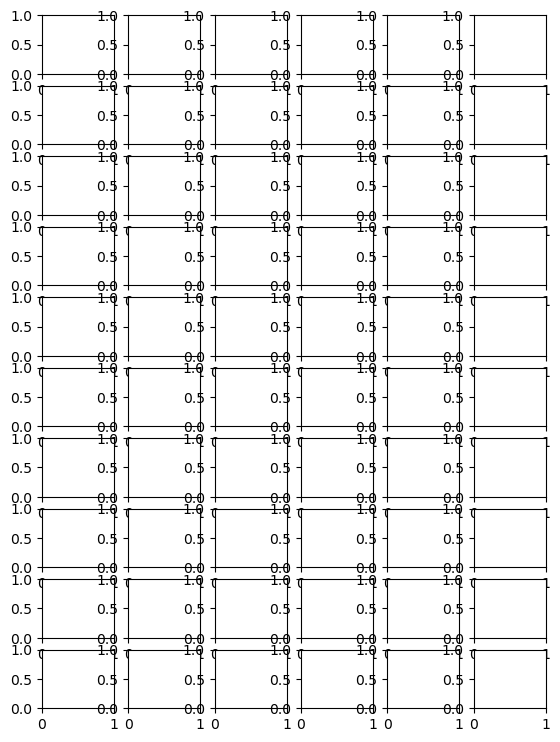

In [25]:
# Create a plot of image chunks
out_png = os.path.join(maindir,'figures/Figure2_dc-denver_image_chunks.png')
plot_image_chunks(
    image_ds_combined, class_mapping, bands_to_plot='all', figsize=(6.5,9), out_file=out_png,
    rgb_dc = rgb_fp_dc, rgb_denver = rgb_fp_denver
)

In [ ]:
gc.collect()